In [1]:
import cv2
import os
from transformers import ViTFeatureExtractor, ViTModel
import math
from collections import Counter
import numpy as np
import pandas as pd
import spacy
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader,Dataset
import torchvision.transforms as T
import torch
from torch.nn import Transformer
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torch import Tensor
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt
import random
import torchmetrics
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(442)
random.seed(42)
np.random.seed(44)
torch.cuda.manual_seed(442)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
class Vocabulary:
    #tokenizer
    spacy_eng = spacy.load("en_core_web_sm")

    
    def __init__(self,freq_threshold):
        #setting the pre-reserved tokens int to string tokens
        self.itos = {0:"<PAD>",1:"<SOS>",2:"<EOS>",3:"<UNK>"}
        
        #string to int tokens
        #its reverse dict self.itos
        self.stoi = {v:k for k,v in self.itos.items()}
        
        self.freq_threshold = freq_threshold
        self.removed=set()
        
    def __len__(self): return len(self.itos)
    
    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in Vocabulary.spacy_eng.tokenizer(text)]
    
    def build_vocab(self, sentence_list):
        frequencies = Counter()
        
        #staring index 4
        idx = 4
        
        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1
 
                #add the word to the vocab if it reaches minum frequecy threshold
        for word in list(frequencies.keys()):
            if frequencies[word] >= self.freq_threshold:
                self.stoi[word] = idx
                self.itos[idx] = word
                idx += 1
            else:
                self.removed.add(word)

    
    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [ self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text ]    
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX= 3,0,1,2

In [3]:
image_path_A = "../input/building-change-detection/Building_change_detection/imgs/A/"
image_path_B="../input/building-change-detection/Building_change_detection/imgs/B/"
image_path_AB_diff="../input/building-change-detection/Building_change_detection/imgs/ABDiff_building/"
image_path_AB="../input/building-change-detection/Building_change_detection/imgs/AB/"
dir_text = "../input/building-change-detection/Building_change_detection/filenames/Descriptions_All_5_Captions_Building_AB.txt"
train_imgs_txt_path="../input/building-change-detection/Building_change_detection/filenames/train_no_random_2.txt"
val_imgs_txt_path="../input/building-change-detection/Building_change_detection/filenames/val_nor_random_2.txt"
test_imgs_txt_path="../input/building-change-detection/Building_change_detection/filenames/test_no_random_2.txt"
jpgs = os.listdir(image_path_A)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 500


In [4]:
file = open(dir_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
    col = line.split(' ')
    if len(col) == 1:
        continue
    filenumber=col[0]
    caption=' '.join(col[1:])
    img_A='A'+filenumber+'.png'
    img_B='B'+filenumber+'.png'
    img_AB_diff='AB'+filenumber+'.png.png'
    img_AB='AB'+filenumber+'.png'
    datatxt.append([filenumber]+[img_A]+[img_B]+[img_AB_diff]+[img_AB]+[caption])
data = pd.DataFrame(datatxt,columns=["img_number","img_A","img_B",'img_AB_diff','img_AB',"caption"])

uni_filenames = np.unique(data.img_AB.values)
data.head(10)

,img_number,img_A,img_B,img_AB_diff,img_AB,caption
0,994,A994.png,B994.png,AB994.png.png,AB994.png,some changes are present in the upper side of ...
1,994,A994.png,B994.png,AB994.png.png,AB994.png,different organization for the objects above
2,994,A994.png,B994.png,AB994.png.png,AB994.png,the objects above the road have changed
3,994,A994.png,B994.png,AB994.png.png,AB994.png,the displacement of the objects above the stre...
4,994,A994.png,B994.png,AB994.png.png,AB994.png,the changes are related to the positions of th...
5,969,A969.png,B969.png,AB969.png.png,AB969.png,no change to mention
6,969,A969.png,B969.png,AB969.png.png,AB969.png,everything is the same
7,969,A969.png,B969.png,AB969.png.png,AB969.png,nothing has changed
8,969,A969.png,B969.png,AB969.png.png,AB969.png,there has not been changes in the area
9,969,A969.png,B969.png,AB969.png.png,AB969.png,there are no changes visible


In [5]:
train_imgs_number_vector=[]
file = open(train_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    if len(col) == 1:
        continue
    filenumber=col[0]
    train_imgs_number_vector.append(filenumber)
train_captions = []
train_nb=[]
for nb in train_imgs_number_vector:
    train_data=data[data["img_number"]==nb]
    for caption  in train_data["caption"].astype(str):
        train_captions.append(caption)
        train_nb.append(nb)

In [6]:
test_imgs_number_vector=[]
file = open(test_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    if len(col) == 1:
        continue
    filenumber=col[0]
    test_imgs_number_vector.append(filenumber)
test_captions = []
test_dict={}
for nb in test_imgs_number_vector:
    test_data=data[data["img_number"]==nb]
    for caption  in test_data["caption"].astype(str):
        l_capt=caption.split()
        if nb in test_dict.keys():
            test_dict[nb].append(l_capt)
        else:
            test_dict[nb]=[l_capt]

In [7]:
test_captions = []
test_nb=[]
for nb in test_imgs_number_vector:
    test_data=data[data["img_number"]==nb]
    for caption  in test_data["caption"].astype(str):
        test_captions.append(caption)
        test_nb.append(nb)

In [8]:
val_imgs_number_vector=[]
file = open(val_imgs_txt_path,'r')
text = file.read()
file.close()
for line in text.split('\n'):
    col = line.split('.')
    if len(col) == 1:
        continue
    filenumber=col[0]
    val_imgs_number_vector.append(filenumber)
val_dict={}
for nb in val_imgs_number_vector:
    val_data=data[data["img_number"]==nb]
    for caption  in val_data["caption"].astype(str):
        l_capt=caption.split()
        if nb in val_dict.keys():
            val_dict[nb].append(l_capt)
        else:
            val_dict[nb]=[l_capt]
val_captions = []
val_nb=[]
for nb in val_imgs_number_vector:
    val_data=data[data["img_number"]==nb]
    for caption  in val_data["caption"].astype(str):
        val_captions.append(caption)
        val_nb.append(nb)

In [9]:
freq_threshold=2
vocab= Vocabulary(freq_threshold)
vocab.build_vocab(train_captions+val_captions)
len(vocab)

196

In [10]:
def feature_extract(img_nb):
    imga_locationa =image_path_A+'A'+img_nb+'.png'
    imgb_locationb =image_path_B+'B'+img_nb+'.png'
    imga = cv2.imread(imga_locationa)
    imgb=cv2.imread(imgb_locationb)
    imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
    imgb=cv2.cvtColor(imgb, cv2.COLOR_BGR2RGB)
    transform=T.Compose([T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),T.Resize(224)])
    imga=transform(imga)
    imgb=transform(imgb)
    #x=np.concatenate((imga,imgb),axis=1)
    return imga,imgb   

In [11]:
train_transform = A.Compose(
    [A.Resize(224,224,p=1),
    A.ShiftScaleRotate(rotate_limit=22,p=0.75),
     ],
    additional_targets={'image0': 'image'}
)

In [12]:
class BuildingChangedataset(Dataset):
    def __init__(self,train_nb,train_captions,vocab,train,transform=None):
        self.transform = transform
        self.imgs = train_nb
        self.captions = train_captions
        self.vocab = vocab
        self.transform=transform
        self.b=train
    
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        caption = self.captions[idx]
        img_nb = self.imgs[idx]
        
        imga_locationa =image_path_A+'A'+img_nb+'.png'
        imgb_locationb =image_path_B+'B'+img_nb+'.png'
        imga = cv2.imread(imga_locationa)
        imgb=cv2.imread(imgb_locationb)
        imga = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
        imgb=cv2.cvtColor(imgb, cv2.COLOR_BGR2RGB)
        #apply the transfromation to the image if train== true
        if self.transform is not None :
            if self.b==True :
                transformed = self.transform(image=imga, image0=imgb)
                imga,imgb=transformed['image'],transformed['image0']
        #numericalize the caption text
        caption_vec = []
        caption_vec += [self.vocab.stoi["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.stoi["<EOS>"]]
        transform=T.Compose([T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),T.Resize(224)])
        imga=transform(imga)
        imgb=transform(imgb)
        return img_nb,torch.FloatTensor(imga),torch.FloatTensor(imgb),torch.tensor(caption_vec)

from torch.nn.utils.rnn import pad_sequence    
    
class CapsCollate:
    """
    Collate to apply the padding to the captions with dataloader
    """
    def __init__(self,pad_idx,batch_first=False):
        self.batch_first = batch_first
    
    def __call__(self,batch):
        imga_batch,imgb_batch,cap_batch=[],[],[]
        for img_nb,imga,imgb,cap in batch:
            imga_batch.append(imga)
            imgb_batch.append(imgb)
            cap_batch.append(cap)
        cap_batch=pad_sequence(cap_batch, padding_value=PAD_IDX)
        imga_batch=pad_sequence(imga_batch,padding_value=PAD_IDX)
        imgb_batch=pad_sequence(imgb_batch,padding_value=PAD_IDX)
        return img_nb,imga_batch,imgb_batch,cap_batch


def get_data_loader(dataset,batch_size,shuffle=False,num_workers=1):

    pad_idx = dataset.vocab.stoi["<PAD>"]
    collate_fn = CapsCollate(pad_idx=pad_idx,batch_first=True)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return data_loader


In [13]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        vit_model = model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit_encoder = vit_model
        for p in self.vit_encoder.parameters():
            p.requires_grad_(True)
    def forward_1(self, images):
        images=images.permute(1,0,2,3)
        features = self.vit_encoder(images) 
        features = features.last_hidden_state
        features=features.permute(1,0,2)
        return features
    def forward(self, img_a,img_b):
        ft_a=self.forward_1(img_a)
        ft_b=self.forward_1(img_b)
        ft=torch.cat([ft_a,ft_b],dim=0)
        return ft  

In [14]:
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        tok=tokens.permute(1,0)
        tok=self.embedding(tok.long()) * math.sqrt(self.emb_size)
        tok=tok.permute(1,0,2)
        return tok
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.cnn_encode=Encoder()
        decoder_layer= nn.TransformerDecoderLayer(emb_size, nhead,dim_feedforward,dropout,"gelu")
        self.decoder=nn.TransformerDecoder(decoder_layer, num_decoder_layers, norm=None)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(emb_size, dropout=dropout)
        self.to_proba=nn.Softmax(dim=2)

    def forward(self,
                src_a: Tensor,
                src_b: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.cnn_encode(src_a,src_b)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs=self.decoder(tgt_emb,src_emb,tgt_mask)
        outs = self.generator(outs)
        return outs

    def encode(self, src_a: Tensor,src_b: Tensor, src_mask: Tensor):
        src_emb = self.cnn_encode(src_a,src_b)
        return src_emb

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(tgt))
        return self.decoder(tgt_emb,memory,None)

In [15]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

# Train

In [16]:
TGT_VOCAB_SIZE = len(vocab)
EMB_SIZE = 768
NHEAD = 12
FFN_HID_DIM = 3072
BATCH_SIZE = 16
NUM_DECODER_LAYERS = 4
Dropout=0
train_dataset=BuildingChangedataset(train_nb,train_captions,vocab,True,train_transform)
val_dataset=BuildingChangedataset(val_nb,val_captions,vocab,False)

transformer = Seq2SeqTransformer(NUM_DECODER_LAYERS,EMB_SIZE,NHEAD,TGT_VOCAB_SIZE,FFN_HID_DIM,Dropout)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.00003, betas=(0.9, 0.99),weight_decay=0.000001, eps=1e-9)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [17]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0
    metric = torchmetrics.Accuracy()
    train_dataloader = get_data_loader(train_dataset,BATCH_SIZE,shuffle=True,num_workers=1)
    for imgnb,src_a,src_b, tgt in train_dataloader:
        src_a = src_a.to(DEVICE)
        src_b = src_b.to(DEVICE)
        tgt = tgt.to(DEVICE)
        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_a, tgt_input)
        src_padding_mask=None
        src_mask=None
        logits = model(src_a,src_b, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        loss.backward()

        optimizer.step()
        losses += loss.item()
        acc = metric((logits.reshape(-1, logits.shape[-1])).cpu(), (tgt_out.reshape(-1)).cpu())
    acc = metric.compute()
    return losses / len(train_dataloader),acc


def evaluate(model):
    model.eval()
    losses = 0
    val_dataloader = get_data_loader(val_dataset,BATCH_SIZE,shuffle=True,num_workers=1)
    metric = torchmetrics.Accuracy()
    for imgnb,src_a,src_b, tgt in val_dataloader:
        src_a = src_a.to(DEVICE)
        src_b = src_b.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src_a, tgt_input)
        src_padding_mask=None
        src_mask=None
        logits = model(src_a,src_b, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)
        
        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        acc = metric(logits.reshape(-1, logits.shape[-1]).cpu(), tgt_out.reshape(-1).cpu())
    acc = metric.compute()
    return losses / len(val_dataloader),acc

In [18]:
def beam_search(model, src_a,src_b, src_mask, max_len, start_symbol,k):
    model.eval()
    src_a = src_a.to(DEVICE)
    src_b = src_b.to(DEVICE)
    src_mask = src_mask

    memory = model.encode(src_a,src_b, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        if (i==0):
            new_ys=[]
            new_probas=[]
            tgt_mask = (generate_square_subsequent_mask(ys.size(0)).type(torch.bool)).to(DEVICE)
            out = model.decode(ys, memory, tgt_mask)
            out = out.transpose(0, 1)
            prob = model.generator(out[:, -1])
            proba=nn.Softmax(dim=1)
            prob=proba(prob)
            p_words, words = torch.topk(prob,k)
            for word in words[0].tolist():
                new_ys.append(torch.cat([ys,torch.ones(1, 1).type_as(src_a.data).fill_(word)], dim=0))
            for word_proba in p_words[0]:
                new_probas.append( torch.log(word_proba ) )
        else:
            new_ys,new_probas=decode_next(model,memory,src_a,k,new_probas,new_ys)
        c = 0
        for y in new_ys:
            if( y.tolist()[-1][0] == EOS_IDX):
                c=c+1
        if (c==k):
            return new_ys,new_probas
    return new_ys,new_probas
        
def decode_next(model,memory,src,k,probas,word_seqs):
    new_word_seqs,new_seq_probas=[],[]
    normalized_seq_probas=[]
    for i in range(k):
        past_proba=probas[i]
        past_word_seq=word_seqs[i]
        if ( past_word_seq.tolist()[-1][0] == EOS_IDX ):
            new_seq_probas.append(past_proba)
            new_word_seqs.append(past_word_seq)
        else :
            tgt_mask = (generate_square_subsequent_mask(past_word_seq.size(0))
                        .type(torch.bool)).to(DEVICE)
            out = model.decode(past_word_seq, memory, tgt_mask)
            out = out.transpose(0, 1)
            scores = model.generator(out[:, -1])
            to_proba=nn.Softmax(dim=1)
            proba=to_proba(scores)
            words_proba, words = torch.topk(proba,k,dim=1)
            for word in words[0].tolist():
                seq=torch.cat([past_word_seq,torch.ones(1, 1).type_as(src.data).fill_(word).to(DEVICE)], dim=0)
                new_word_seqs.append(seq)
            for word_proba in words_proba[0]:
                seq_proba=torch.log(word_proba)+past_proba
                new_seq_probas.append(seq_proba)
    new_seq_probas=torch.tensor(new_seq_probas)
    for j in range(len(new_word_seqs)):
        normalized_seq_probas.append( new_seq_probas[j]/(len(new_word_seqs[j])) )
    _,indexes=torch.topk(torch.tensor(normalized_seq_probas),k,dim=0)
    topk_seq,topk_probas=[],[]
    for idx in indexes:
        topk_seq.append(new_word_seqs[idx])
        topk_probas.append(new_seq_probas[idx])
    return topk_seq,topk_probas
def translate_beam(model: torch.nn.Module, nb):
    model.eval()
    src_a,src_b=feature_extract(nb)
    src_a,src_b=src_a.unsqueeze(1),src_b.unsqueeze(1)
    src_mask = None
    topk_seq,topk_probas = beam_search(transformer, src_a,src_b, None,40, BOS_IDX,5)
    top_seq=topk_seq[0].flatten()
    caption_predicted=[vocab.itos[token] for token in top_seq.tolist()]
    caption_predicted=" ".join(caption_predicted).replace("<SOS>", "").replace("<EOS>", "")
    caption_predicted=caption_predicted.rstrip()
    return caption_predicted

In [19]:
# function to generate output sequence using greedy algorithm 
def greedy_decode(model, src_a,src_b, src_mask, max_len, start_symbol):
    src_a,src_b = src_a.to(DEVICE),src_b.to(DEVICE)
    src_mask = src_mask

    memory = model.encode( src_a,src_b, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        p=nn.Softmax(dim=1)
        prob=p(prob)
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src_a.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys
def translate(model: torch.nn.Module, nb):
    model.eval()
    src_a,src_b=feature_extract(nb)
    src_a,src_b=src_a.unsqueeze(1),src_b.unsqueeze(1)
    src_mask = None
    tgt_tokens = greedy_decode(
        model,  src_a,src_b, src_mask, max_len=40, start_symbol=BOS_IDX).flatten()
    caption_predicted=[vocab.itos[token] for token in tgt_tokens.tolist()]
    caption_predicted=" ".join(caption_predicted).replace("<SOS>", "").replace("<EOS>", "")
    caption_predicted=caption_predicted.rstrip()
    return caption_predicted


In [20]:
bleu1=torchmetrics.BLEUScore(n_gram=1)
bleu2=torchmetrics.BLEUScore(n_gram=2)
bleu3=torchmetrics.BLEUScore(n_gram=3)
bleu4=torchmetrics.BLEUScore(n_gram=4)
def evaluate_bleu_img(model,nb,dic):
    real_captions =[dic[nb]]
    caption_predicted= [translate_beam(model,nb).split()]
    score1 =bleu1(real_captions,caption_predicted)
    score2 =bleu2(real_captions,caption_predicted)
    score3 =bleu3(real_captions,caption_predicted)
    score4 =bleu4(real_captions,caption_predicted)
    return score1,score2,score3,score4,real_captions,caption_predicted
def evaluate_bleu_dataset(model,dic):
    avg_sc1=0
    avg_sc2=0
    avg_sc3=0
    avg_sc4=0
    for nb in dic.keys():
        score1,score2,score3,score4,references,candidate=evaluate_bleu_img(model,nb,dic)
        avg_sc1+=score1
        avg_sc2+=score2
        avg_sc3+=score3
        avg_sc4+=score4
    avg_sc1/=len(dic.keys())
    avg_sc2/=len(dic.keys())
    avg_sc3/=len(dic.keys())
    avg_sc4/=len(dic.keys())
    return float(avg_sc1),float(avg_sc2),float(avg_sc3),float(avg_sc4)

In [21]:
from timeit import default_timer as timer
NUM_EPOCHS =5
min_val=100
best_ep=0
max_sc=0
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss,train_acc = train_epoch(transformer, optimizer)
    val_loss,val_acc = evaluate(transformer)
    sc1,sc2,sc3,sc4=evaluate_bleu_dataset(transformer,val_dict)
    end_time = timer()
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, Train acc: {train_acc*100:.3f},Val acc: {val_acc*100:.3f} "f"Epoch time = {(end_time - start_time):.3f}s"))
    print((f"Bleu1 :{sc1*100:.2f}, Bleu2 :{sc2*100:.2f}, Bleu3 :{sc3*100:.2f}, Bleu4 :{sc4*100:.2f}" ))
    if ( sc4*100 >= max_sc  ):
        max_sc=sc4*100
        torch.save(transformer.state_dict(), "bleu_transformer")
        print("Bleu_Model saved!")
        best_ep=epoch
    print("_______")
    torch.save(transformer.state_dict(), "last_transformer")

Epoch: 1, Train loss: 3.082, Val loss: 2.383, Train acc: 21.538,Val acc: 26.761 Epoch time = 86.468s
Bleu1 :63.83, Bleu2 :51.29, Bleu3 :42.59, Bleu4 :34.31
Bleu_Model saved!
_______
Epoch: 2, Train loss: 2.156, Val loss: 2.044, Train acc: 30.001,Val acc: 30.450 Epoch time = 80.969s
Bleu1 :66.88, Bleu2 :54.12, Bleu3 :44.84, Bleu4 :34.06
_______
Epoch: 3, Train loss: 1.863, Val loss: 1.932, Train acc: 33.134,Val acc: 31.278 Epoch time = 80.292s
Bleu1 :69.45, Bleu2 :56.17, Bleu3 :45.81, Bleu4 :34.32
Bleu_Model saved!
_______
Epoch: 4, Train loss: 1.681, Val loss: 1.897, Train acc: 35.196,Val acc: 31.841 Epoch time = 81.973s
Bleu1 :75.86, Bleu2 :63.69, Bleu3 :51.44, Bleu4 :43.90
Bleu_Model saved!
_______
Epoch: 5, Train loss: 1.548, Val loss: 1.852, Train acc: 36.512,Val acc: 31.677 Epoch time = 80.109s
Bleu1 :69.45, Bleu2 :58.04, Bleu3 :47.17, Bleu4 :35.60
_______


In [22]:
transformer.load_state_dict(torch.load("./bleu_transformer"))
evaluate_bleu_dataset(transformer,test_dict)

(0.7129854559898376,
 0.5889293551445007,
 0.46870630979537964,
 0.38868945837020874)

5976
BLEU-1 score: 81.43535614013672
BLEU-2 score: 70.0884017944336
BLEU-3 score: 60.572792053222656
BLEU-4 score: 54.18220138549805
Real Caption  1 : a small road appears in the right lower corner and no tree remains in the right upper corner
Real Caption  2 : the trees have increased in size except the ones removed from the upper right corner
Real Caption  3 : a new road is present below and the grass appears more green all over the scene except in the area above where some trees are removed
Real Caption  4 : the trees were removed from the upper part an object and a new way appears in the field
Real Caption  5 : the changes are related to the vegetation and to the object
Predicted Caption: the changes are related to the size of the trees


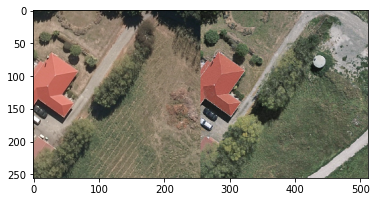

5186
BLEU-1 score: 84.33740234375
BLEU-2 score: 75.1213150024414
BLEU-3 score: 63.79231262207031
BLEU-4 score: 53.11878204345703
Real Caption  1 : more objects appear all over the scene
Real Caption  2 : the changes are related to the number and to the organization of the objects present in the scene
Real Caption  3 : many objects of different size appear all around
Real Caption  4 : many new objects appear and the grass changes color
Real Caption  5 : there are some differences in the grass cover and new objects are present
Predicted Caption: the changes are related to the new objects and to the vehicles


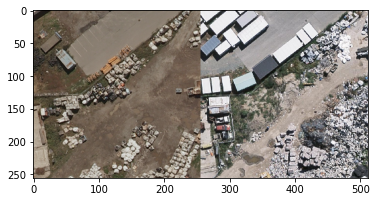

1550
BLEU-1 score: 100.0
BLEU-2 score: 94.86832427978516
BLEU-3 score: 88.79039764404297
BLEU-4 score: 71.57845306396484
Real Caption  1 : the size of the trees has changed and the vehicles are different
Real Caption  2 : less vehicles appear and the trees have different size
Real Caption  3 : some changes are related to the trees and to the vehicles
Real Caption  4 : only the vehicles and the trees have changed
Real Caption  5 : there are slight changes to the vehicles and the trees
Predicted Caption: the changes are related to the vehicles and to the trees


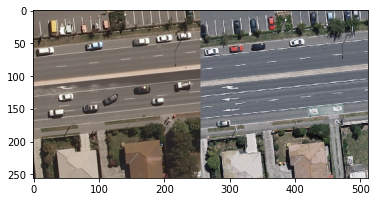

131
BLEU-1 score: 81.43535614013672
BLEU-2 score: 75.7041244506836
BLEU-3 score: 68.69047546386719
BLEU-4 score: 59.541648864746094
Real Caption  1 : the grass has grown some trees have been removed and the platform appears more large
Real Caption  2 : less trees are present near the platform that appears more large
Real Caption  3 : the platform is more large there are less trees and the grass appears more green
Real Caption  4 : the grass cover has changed and the size of trees decreased
Real Caption  5 : the changes are related to the vegetation present
Predicted Caption: the changes are related to the size of the trees


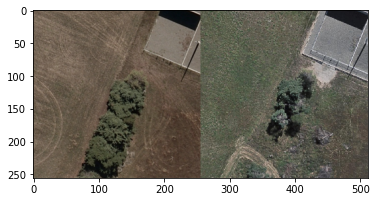

1672
BLEU-1 score: 42.437286376953125
BLEU-2 score: 42.437286376953125
BLEU-3 score: 39.39529037475586
BLEU-4 score: 37.34955596923828
Real Caption  1 : the building on the left side has changed and more vehicles are present
Real Caption  2 : many vehicles are parked on the right of the building that appears different
Real Caption  3 : all the changes are related to the presence of more vehicles in the parking and to the construction of a new building on the left
Real Caption  4 : the changes are in the building on the left and in the number of the vehicles
Real Caption  5 : there are some differences in the building on the left and in the vehicles
Predicted Caption: the changes are related to the vehicles


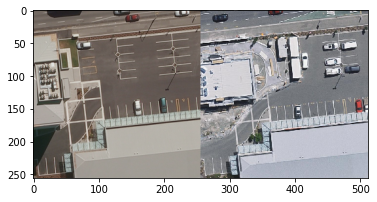

2827
BLEU-1 score: 100.0
BLEU-2 score: 100.0
BLEU-3 score: 97.14128112792969
BLEU-4 score: 90.36019897460938
Real Caption  1 : the vehicles and the trees appear different and a new roof is present near the right upper corner
Real Caption  2 : all the changes are related to the vehicles to the roofs and to the size of the trees
Real Caption  3 : a new roof appears near the right upper corner the trees have changed in size and the vehicles are different
Real Caption  4 : a new building was constructed on the right and vehicles and trees are different
Real Caption  5 : changes are visible in the buildings vehicles and in the trees
Predicted Caption: the changes are related to the vehicles and to the size of the trees


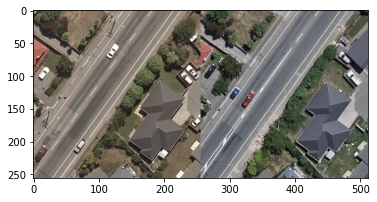

2888
BLEU-1 score: 38.940040588378906
BLEU-2 score: 20.814327239990234
BLEU-3 score: 0.0
BLEU-4 score: 0.0
Real Caption  1 : two roads are constructed with some grass and trees all around
Real Caption  2 : roads trees and grass appear on the bare soil surface
Real Caption  3 : new roads are built in the area where some grass and small trees appear
Real Caption  4 : two new wide roads were built and some trees appear in the upper part
Real Caption  5 : new roads and trees appear
Predicted Caption: the changes are related to the new roads


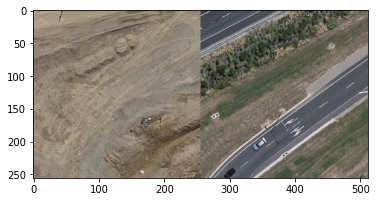

5810
BLEU-1 score: 74.30381774902344
BLEU-2 score: 56.7504768371582
BLEU-3 score: 38.22160720825195
BLEU-4 score: 0.0
Real Caption  1 : the size of the trees has changed and the vehicles on the road are different
Real Caption  2 : everything remains the same except the trees and the vehicles
Real Caption  3 : a slight change is present and is related to the different vehicles and to the size of the trees
Real Caption  4 : trees has grown and vehicles has changed position
Real Caption  5 : the size of the trees and the position of the vehicles have changed
Predicted Caption: the changes are related to the vehicles


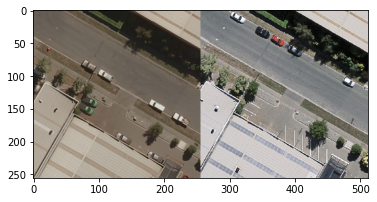

6053
BLEU-1 score: 37.5
BLEU-2 score: 0.0
BLEU-3 score: 0.0
BLEU-4 score: 0.0
Real Caption  1 : the vehicles above the grass field are different
Real Caption  2 : only the vehicles have changed
Real Caption  3 : everything remains the same but the parked vehicles
Real Caption  4 : the vehicles changed position
Real Caption  5 : only the position of the vehicles has changed
Predicted Caption: the changes are related to the new roads


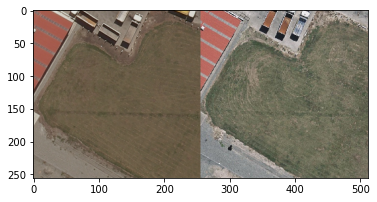

7415
BLEU-1 score: 70.0
BLEU-2 score: 39.440528869628906
BLEU-3 score: 0.0
BLEU-4 score: 0.0
Real Caption  1 : a road is present on the right next to the constructions present near the left top corner
Real Caption  2 : everything has changed and new houses and roads appear
Real Caption  3 : new houses and roads are constructed on the grass field and some vehicles are present all around
Real Caption  4 : two new houses are built on the left side of a new road and some vehicles appear
Real Caption  5 : some constructions are built and new vehicles appear
Predicted Caption: the changes are related to the color of the grass


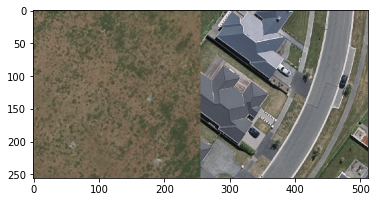

In [24]:
l_v =random.sample(range(len(val_dict.keys())),10)
for rid in l_v:
    nb = list(val_dict.keys())[rid]
    print(nb)
    score1,score2,score3,score4,references,candidate=evaluate_bleu_img(transformer,nb,val_dict)
    print(f"BLEU-1 score: {score1*100}")
    print(f"BLEU-2 score: {score2*100}")
    print(f"BLEU-3 score: {score3*100}")
    print(f"BLEU-4 score: {score4*100}")
    for c in range(len(references[0])):
      print('Real Caption ',c+1,':',' '.join(references[0][c]))
    print ('Predicted Caption:', ' '.join(candidate[0]))
    image=image_path_AB+'AB'+str(nb)+'.png'
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.pause(0.001)

7218
BLEU-1 score: 83.0091552734375
BLEU-2 score: 77.8694839477539
BLEU-3 score: 67.50360107421875
BLEU-4 score: 56.968223571777344
Real Caption  1 : the color of the grass field has changed and a construction appears near the left lower corner
Real Caption  2 : the grass appears different and a new roof is present on the right lower corner
Real Caption  3 : the changes are related to the new construction near the left lower corner and to the color of the grass
Real Caption  4 : the field on the right changed and the grass color is different
Real Caption  5 : there are differences in the field on the right side and in the color of the grass
Predicted Caption: the changes are related to the grass and to the trees


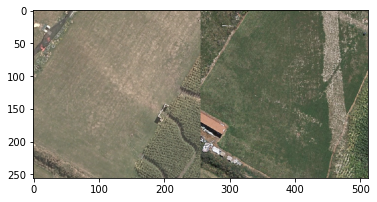

2314
BLEU-1 score: 70.0
BLEU-2 score: 55.77733612060547
BLEU-3 score: 48.86323928833008
BLEU-4 score: 42.728702545166016
Real Caption  1 : only the size of the trees has changed
Real Caption  2 : the trees appear with a different size
Real Caption  3 : nothing has changed but the size of the trees
Real Caption  4 : there are no changes except the size of trees and the position of vehicles
Real Caption  5 : only the trees have increased in size
Predicted Caption: the changes are related to the size of the trees


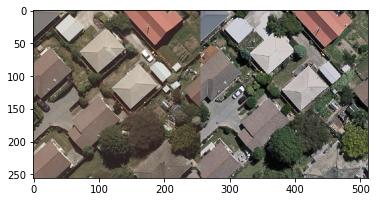

689
BLEU-1 score: 58.10640335083008
BLEU-2 score: 23.034103393554688
BLEU-3 score: 0.0
BLEU-4 score: 0.0
Real Caption  1 : the surface of the grass field has changed and a parking appears
Real Caption  2 : no tree is present and only one vehicles remains near the building
Real Caption  3 : there are less vehicles and many new objects next to the buildings
Real Caption  4 : new parking was built on the right trees were removed and vehicles are different
Real Caption  5 : some objects appear near the building and some vehicles have been removed
Predicted Caption: the changes are related to the objects and to the vehicles


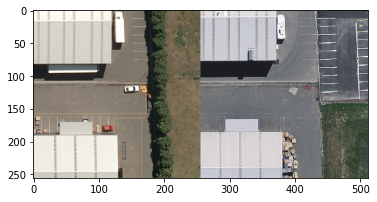

3690
BLEU-1 score: 79.80538940429688
BLEU-2 score: 67.6205825805664
BLEU-3 score: 59.70842361450195
BLEU-4 score: 51.81294250488281
Real Caption  1 : the small objects present and the size of the trees have changed
Real Caption  2 : the objects present around the houses are different and many trees have increased in size
Real Caption  3 : there is a slight change related to the objects around the houses and to the size of the trees
Real Caption  4 : only the objects near the houses and the trees are different
Real Caption  5 : the objects and the trees have visibly changed
Predicted Caption: the changes are related to the vehicles and to the size of the trees


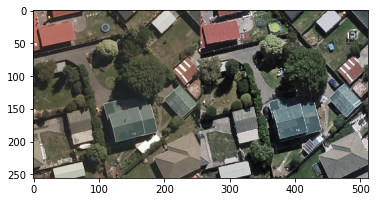

2375
BLEU-1 score: 70.0
BLEU-2 score: 68.3130111694336
BLEU-3 score: 61.56382751464844
BLEU-4 score: 50.81327438354492
Real Caption  1 : nothing has changed but the size of the trees
Real Caption  2 : the trees present appear with a different size
Real Caption  3 : the change is only related to the trees
Real Caption  4 : only the trees have grown
Real Caption  5 : the size of the trees has increased
Predicted Caption: the changes are related to the size of the trees


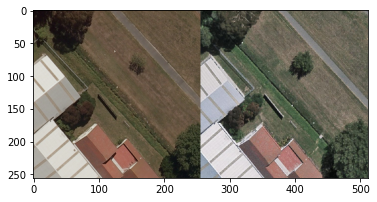

In [25]:
l_t = random.sample(range(len(test_dict.keys())),5)
for rid in l_t:
    nb = list(test_dict.keys())[rid]
    print(nb)
    score1,score2,score3,score4,references,candidate=evaluate_bleu_img(transformer,nb,test_dict)
    print(f"BLEU-1 score: {score1*100}")
    print(f"BLEU-2 score: {score2*100}")
    print(f"BLEU-3 score: {score3*100}")
    print(f"BLEU-4 score: {score4*100}")
    for c in range(len(references[0])):
      print('Real Caption ',c+1,':',' '.join(references[0][c]))
    print ('Predicted Caption:', ' '.join(candidate[0]))
    image=image_path_AB+'AB'+str(nb)+'.png'
    temp_image = np.array(Image.open(image))
    plt.imshow(temp_image)
    plt.pause(0.001)